# Main figure for the paper with downstream analysis - Mouse cortex

In this notebook, we present the main downstream analysis to explore the impact of cellular niche and cellular composition on cell type specific gene expression. Here, we show the mapping, the spatial selection of the cells, the differences in GEx patterns, exploration of DEGs, differences in colocalization and cell-cell communication. Moreover, we orgnize the notebook as the main figure of the paper. 

In [1]:
global_path = './cell-cell-communication/' ## Path to the github downloaded repository

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pickle
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import random
import ktplotspy as kpy
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

from sklearn.metrics import roc_curve, roc_auc_score, auc,fbeta_score, precision_score
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import distance
from scipy.stats import spearmanr


import sys
sys.path.insert(1, global_path + 'Functions/')
from mapping_exploration import abundances_figure, assign_loc2spot, prepare_celltrek
from downstream_analysis import pseudoreplicates, obtain_deg, compute_colocalization, run_cellphonedb, plot_CCCvsColoc
plt.rcParams['font.family'] = 'FreeSans' 
from adjustText import adjust_text
title_size = 12
labelout_size = 10
label_size = 8
ticks_size = 6

In [3]:
# Load adata objects: scRNA-seq and ST
adata = sc.read(global_path + 'Data/Brain/scdata.h5ad')
adata_st = sc.read(global_path + 'Data/Brain/stdata.h5ad')
## Also the coordinates in the same system than the CellTrek results
coords = pd.read_csv(global_path + 'Data/Brain/stdata_coods.csv')
coords['Unnamed: 0'] = coords['Unnamed: 0'].str.replace('.', '-')

# CellTrek results
## It is important that l5 and total file are from the same prediction
meta_cells_charting_l5 = pd.read_csv(global_path + 'Results/Brain/CellTrek/meta_cellcharting_l5modules.csv')
meta_cells_total = pd.read_csv(global_path+'Results/Brain/CellTrek/meta_cellcharting.csv')


# Figure 1A: Representation of spatial mapping - CellTrek

Here we are presenting the spatial distribution of 4 cellular types present in the tissue. As we are using results from CellTrek, we first need to map the locations of CellTrek results to the closest spot. Then we convert it to counts per spot of each cell type and normalize the abundances for representation purposes. 

## We first need to map the CellTrek locations to the spot coordinates

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

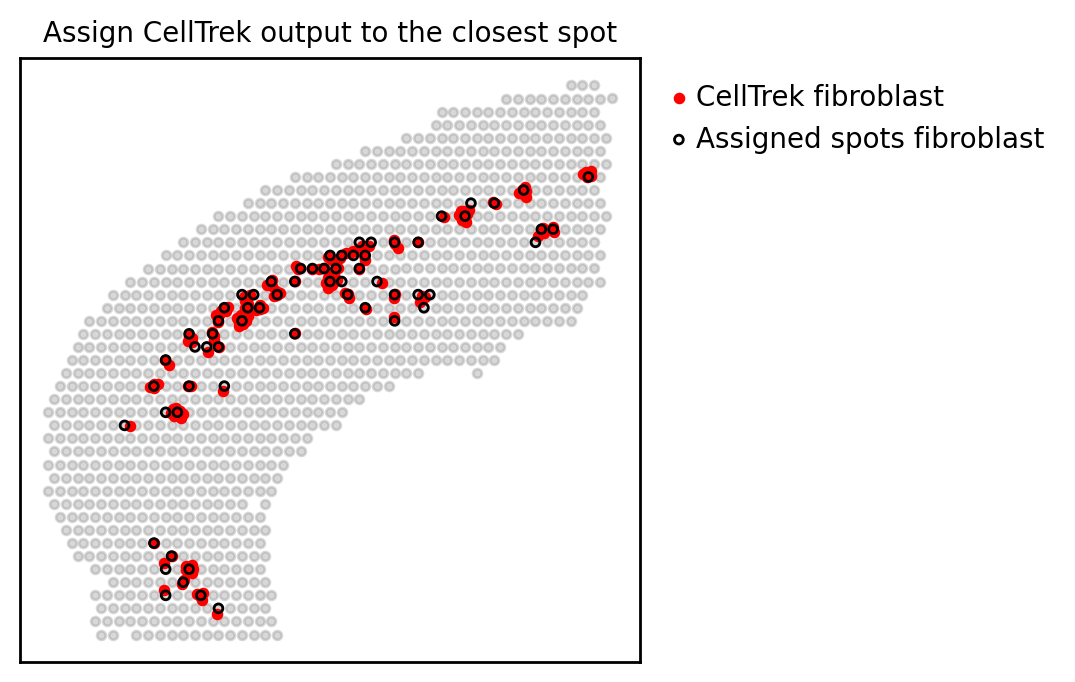

In [4]:
# Assign the spot to each cell
celltrekfile = global_path+'Results/Brain/CellTrek/meta_cellcharting.csv'
coordsfile = global_path + 'Data/Brain/stdata_coods.csv'
meta_cells_total = assign_loc2spot(celltrekfile, coordsfile)
meta_cells_total.to_csv(global_path + 'Results/Brain/CellTrek/meta_cellcharting_spot_info.csv', index = False)

######## Check point of the spot assignment ########
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi = 200)

### Background spot coordinates 
xs = coords.imagerow.values
ys = coords.imagecol.values
axs.scatter(ys, -xs, s=10, c= 'grey', alpha = 0.3)

### Spot coordinates of the L5 IT neurons
coords_fibro = meta_cells_total[meta_cells_total.cell_type == 'L5 IT'][['imagerow', 'imagecol']].drop_duplicates()

### Plot the spot coordinates of the L5 IT neurons and the CellTrek results to see if the spot assignment is correct
axs.scatter(meta_cells_charting_l5.coord_y.values, -meta_cells_charting_l5.coord_x.values, s=10,  color = 'red', label='CellTrek fibroblast', alpha=1)
axs.scatter(coords_fibro.imagecol.values, -coords_fibro.imagerow.values, s=10,  facecolors = 'none',edgecolors = 'black', label='Assigned spots fibroblast', alpha=1)
axs.set_xlabel('')
axs.set_ylabel('')
axs.set_title('Assign CellTrek output to the closest spot', size = 10)
axs.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axs.legend(frameon = False, handlelength= 1, handletextpad = 0.1, bbox_to_anchor = (1,1))


In [5]:
query_cells = ['L5 IT', 'L4', 'Sst', 'L6 IT']
## Compute abundances 
abundances, coords = prepare_celltrek(meta_cells_total, query_cells)

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

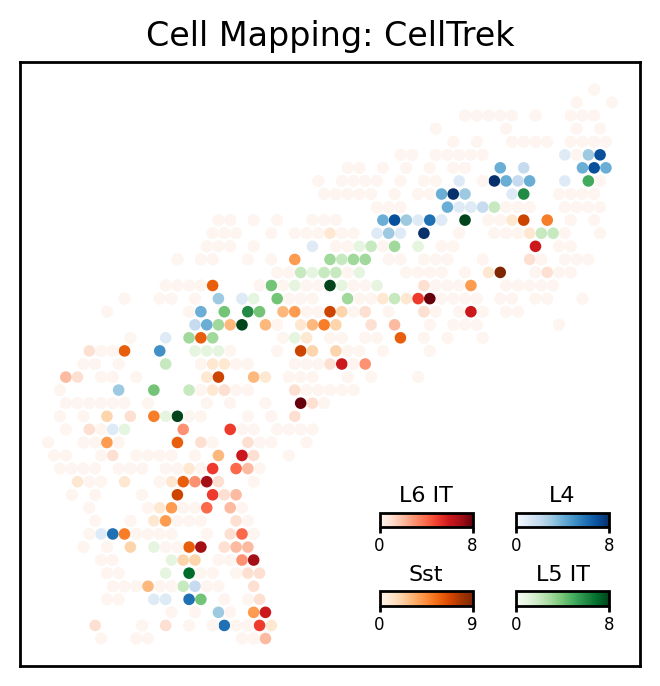

In [6]:
## Inicialize figure
fig, ax_scatter = plt.subplots(figsize=(4, 4), dpi=200)

## Define colorbar bounds
colorbar_bounds = [
    [0.8, 0.1, 0.15, 0.024],  # Bottom right corner, first column
    [0.8, 0.23, 0.15, 0.024],   # Second row
    [0.58, 0.1, 0.15, 0.024],  # First column, one row above
    [0.58, 0.23, 0.15, 0.024],   # Second row
]
## Figure
abundances_figure(abundances, coords, ax_scatter, query_cells, 'Cell Mapping: CellTrek', colorbar = True, colorbar_bounds = colorbar_bounds)



# Categorize selected cell type (L5 IT) into distict groups based on their gene module activity (inner/outer)

Once we have explore the mapping result, we take the result from the CellTrek - SCoexp  and define the two regions according to the highest module score which correspond to cells in the outer and inner part of the layer. After defining the spatial regions, we can explore how variations in the part of the layer affect the gene expressoin of the cell of interest and communication dynamics. 

In [7]:
## Add spot coordinates to the CellTrek L5 IT results
id2spot = dict(zip(meta_cells_total.id_raw, meta_cells_total.spot))
meta_cells_charting_l5['spot'] = [id2spot[i] for i in meta_cells_charting_l5.id_raw]

id2coorx = dict(zip(meta_cells_total.id_raw, meta_cells_total.imagerow))
meta_cells_charting_l5['imagerow'] = [id2coorx[i] for i in meta_cells_charting_l5.id_raw]

id2coory = dict(zip(meta_cells_total.id_raw, meta_cells_total.imagecol))
meta_cells_charting_l5['imagecol'] = [id2coory[i] for i in meta_cells_charting_l5.id_raw]

meta_cells_charting_l5 = meta_cells_charting_l5.set_index('id_raw')

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

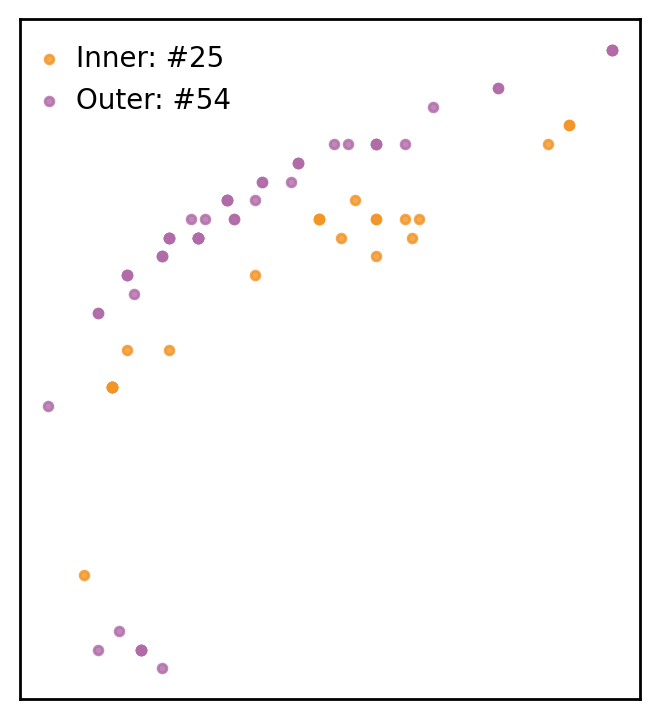

In [8]:
### Select the ind
module = []

# Iterate through each row of the DataFrame
for index, row in meta_cells_charting_l5[['CC_1', 'CC_2', 'CC_3']].iterrows():
    # Identify the column with the highest value
    col_max = row.idxmax()
    # Append the index to the corresponding list
    if col_max == 'CC_1':
        module.append('CC1')
    elif col_max == 'CC_2':
        module.append('CC2')
    elif col_max == 'CC_3':
        module.append('CC3')

meta_cells_charting_l5['cluster'] = module


### Check the distribution of the cells in the space
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4.5), dpi = 200)

xs_c1 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1'].imagerow.values
ys_c1 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1'].imagecol.values

xs_c2 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2'].imagerow.values
ys_c2 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2'].imagecol.values

axs.scatter(ys_c1, -xs_c1, s=10, color = '#F39426', alpha = 0.8, label = 'Inner: #%s' %(len(xs_c1)))
axs.scatter(ys_c2, -xs_c2, s=10, color = '#B16BA8', alpha = 0.8, label = 'Outer: #%s' %(len(xs_c2)))

axs.set_xlabel('')
axs.set_ylabel('')
axs.legend(frameon = False, handlelength=0.3)
axs.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

In [9]:
## Subset the dataframe and split it into the two spatial groups
# select the cells according to the loc
l5_inner = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1']
l5_outer = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2']

Once we have defined the groups of cells based on spatial location, we can start with the downstream analysis to expore differences in their GEx and communication dynamics

# Figure 1C: Distances between L5 IT cells in same locations vs different locations

Explore overall differences in GEx profiles in relation to cell spatial locations computing pairwise cosine distances between log-normalized GEx vectors

In [10]:
############## Select ids according to location ###############
# select the id of the cells according to the location and select a random background background
# We need to select the ids for obtaining the expression from the adata_ref
id_inner = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1'].index.tolist()
id_outer = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2'].index.tolist()
id_all = np.random.choice(adata.obs.index, len(meta_cells_charting_l5.index.tolist()), replace=False)

In [11]:
############# Distances according to location #############
### Select GEx
GEX_CC1 = adata[adata.obs.index.isin(id_inner)].X.toarray()
GEX_CC2 = adata[adata.obs.index.isin(id_outer)].X.toarray()
GEX = adata[adata.obs.index.isin(id_all)].X.toarray()

### Calculate distances
all_cosine = pdist(GEX, 'cosine')
CC1_cosine = pdist(GEX_CC1, 'cosine')
CC2_cosine = pdist(GEX_CC2, 'cosine')
CC1_CC2 = cdist(GEX_CC1, GEX_CC2, 'cosine')

In [12]:

print('Mean cosine distance between L5 IT in inner part: %s \nMean cosine distance between L5 IT in outer part: %s \nMean cosine distance between cells in diferent locations: %s'%(np.mean(CC1_cosine), np.mean(CC2_cosine), np.mean(np.concatenate(CC1_CC2))))

Mean cosine distance between L5 IT in inner part: 0.11258973763965612 
Mean cosine distance between L5 IT in outer part: 0.11276504023067525 
Mean cosine distance between cells in diferent locations: 0.1246260055322731


Text(0.5, 1.0, 'GEx distances between L5 IT neurons \n in different positions')

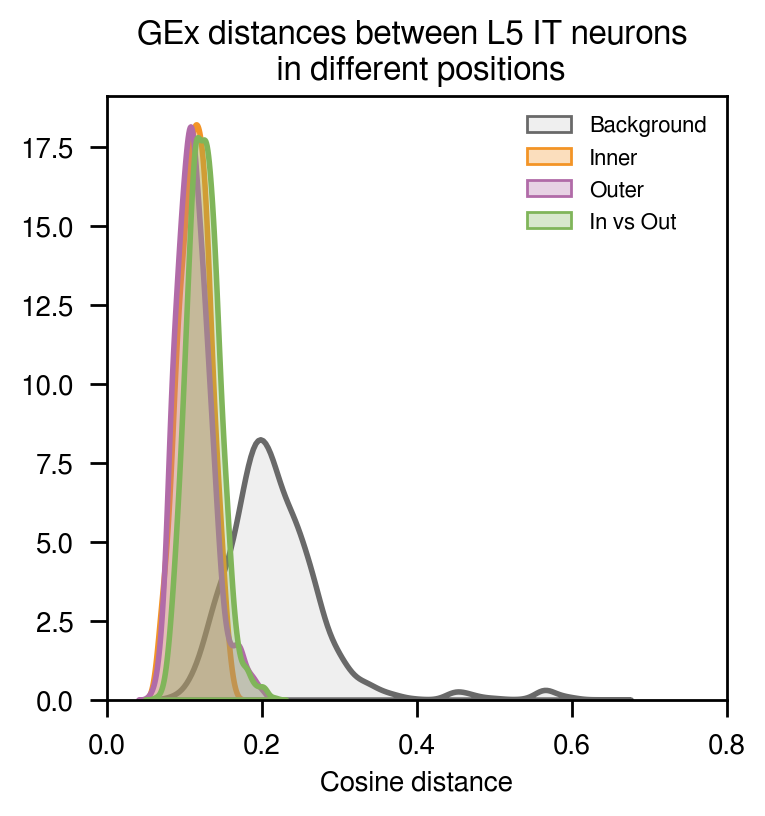

In [13]:
fig, axs = plt.subplots(figsize=(4, 4), dpi = 200)

sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = axs, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(CC1_cosine, label = 'Inner', color = '#F39426' ,ax = axs, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(CC2_cosine, label = 'Outer', color = '#B16BA8', ax = axs, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(CC1_CC2), label = 'In vs Out', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2)


legend = axs.legend(frameon = False, fontsize = label_size, loc= 'upper right')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

axs.set_xlim(0,0.8)
axs.set_xlabel('Cosine distance', fontsize=labelout_size)
axs.set_ylabel('')
axs.tick_params(axis='both', which='major', labelsize=labelout_size)
axs.set_title('GEx distances between L5 IT neurons \n in different positions', fontsize=title_size)


In this example, we can see that the L5 IT cells that are in the same part of the layer are subtly more similar between them than when we compare betwee different parts of the layer. But the distributions are very similar. 

# Figure 1E: Volcano plot

In [11]:
## Add cell group to the adata object
adata_l5 = adata[adata.obs.index.isin(meta_cells_charting_l5.index)]
adata_l5.obs['cluster'] = [meta_cells_charting_l5[meta_cells_charting_l5.index == i].cluster.values[0] for i in adata_l5.obs.index]
adata_l5.var_names_make_unique()
adata_l5 = adata_l5[adata_l5.obs.cluster.isin(['CC1', 'CC2'])]
adata_l5.obs.cluster = adata_l5.obs.cluster.astype('category')


In [24]:
## Build the adata object for the pseudoreplicates
pb = pseudoreplicates(adata_l5, 'cluster', n = 3)
## Obtain the DEG
loc1vsloc2 = obtain_deg(pb,'CC1', 'CC2')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 12.44 seconds.

Fitting dispersion trend curve...
... done in 8.82 seconds.

Fitting MAP dispersions...
... done in 15.34 seconds.

Fitting LFCs...
... done in 8.32 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: condition CC1 vs CC2
                  baseMean  log2FoldChange     lfcSE      stat    pvalue   
genes.human                                                                
0610007P14Rik  1700.141770        0.145463  0.172520  0.843167  0.399135  \
0610009B22Rik  1735.602786        0.615093  0.158035  3.892121  0.000099   
0610009E02Rik     3.217541        2.592505  3.817530  0.679105  0.497071   
0610009L18Rik   123.338047        0.626991  0.636489  0.985078  0.324586   
0610009O20Rik   122.929108        0.677294  0.719718  0.941054  0.346677   
...                    ...             ...       ...       ...       ...   
ZYG11B         1764.114009       -0.008086  0.191733 -0.042174  0.966360   
ZYX             591.720426        0.170867  0.301274  0.567147  0.570614   
ZZEF1           246.367822        0.055722  0.460772  0.120932  0.903745   
ZZZ3            651.119544       -0.101162  0.352634 -0.286874  0.774209   
l7Rn6          2312.142935   

... done in 2.35 seconds.



In [25]:
## Select significant DEGs adjusted p-value < 0.05 and log2FC > 1
loc1vsloc2.reset_index(inplace = True)
loc1vsloc2_sig = loc1vsloc2[loc1vsloc2.padj < 0.05]
loc1vsloc2_sig = loc1vsloc2_sig[abs(loc1vsloc2_sig.log2FoldChange) > 1]

In [32]:
loc1vsloc2.sort_values('padj', inplace = True)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


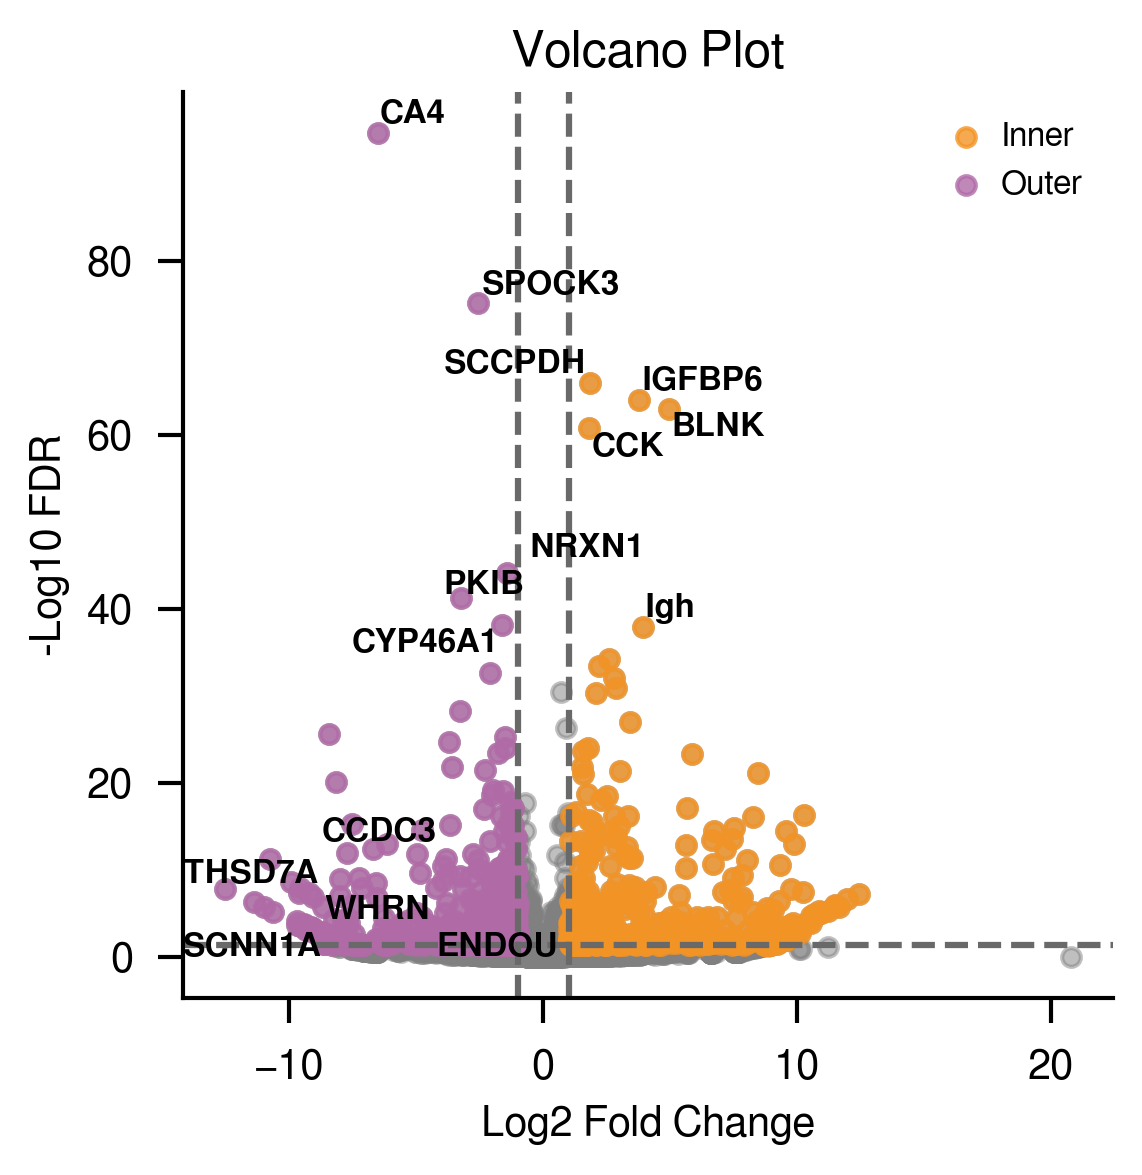

In [17]:
##### Select genes for the volcano plot text #####
# Select the top 5 up and down regulated genes 
top_dw = loc1vsloc2.sort_values('log2FoldChange').head(5)
top_up = loc1vsloc2.sort_values('log2FoldChange').tail(5)
top_all = top_dw.merge(top_up, how = 'outer')
# Select the genes with the lowest p-values
top_pval = loc1vsloc2_sig.sort_values('padj', ascending = True).head(10)

##### Create the volcano plot ####

# Transform data for plotting
log_fold_changes = loc1vsloc2.log2FoldChange.values      # Log2 fold change
neg_log_p_values = -np.log10(loc1vsloc2.padj.values)        # -Log10 p-value


# Create the volcano plot
fig = plt.figure(figsize=(4,4), dpi = 300)

# Scatter plot specifying points of interest
# Let's say significant points are those with abs(log fold change) > 1 and -log p-value > 1.5
plt.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
plt.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20, label = 'Inner')

plt.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20, label = 'Outer')

# Add gene names for the top genes
texts = []
for index, row in top_pval.iterrows():
        texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['genes.human'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['padj'] > 0.05:
                continue
        if row['genes.human'] not in top_pval['genes.human'].tolist():
                texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['genes.human'], fontsize=label_size, fontweight = 'bold'))
try:
        adjust_text(texts)
except:
        print('No DEGs')


# Highlighting the threshold line for p-value
plt.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
plt.axvline(x=1, color='dimgray', linestyle='--')
plt.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
plt.xlabel('Log2 Fold Change', fontsize=labelout_size)
plt.ylabel('-Log10 FDR', fontsize=labelout_size)
plt.title('Volcano Plot', fontsize=title_size)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.legend(frameon = False, fontsize = label_size, handlelength=0.5)
plt.tick_params(axis='both', which='major', labelsize=labelout_size)


There is a lot of differentially expressed genes between the regions (as was expected because of the method to select the locations).  Consistent with the original CellTrek results, neurons situated in the inner region of the layer showed significant activity for  COL27A1 and COL6A1, whereas neurons in the outer section were active in WHRN and ENDOU. 


# Figure 1D: Co-localization vs cell-cell interactions

We wanted to correlate colocalization with cell-cell interactions as it is expected that colocalizing cells would be more likely to interact. So the idea was to use the colozalization patterns to evaluate the prediction of the intercellular communication

## Colocalization calculation

For defining the different spatial groups, we visually looked at mapping results. But we wanted to quantify this spatial colocalization of different cell types. So we compute a binary matrix (presence 1 or not presence 0 of this cell type in the specific spot) and we use the columns of this matrix as the spot signature of the cell type (indicating the spatial distribution). Then, to explore the colocalization we compute Jaccard similarities, with higher JS indicating a higher colocalization (cell types that tend to be in the same spots). We divide cancer cells into the previous defined groups so we can explore different colocalization patterns between them. 

In [12]:
# Select the unique spots where each of the cancer cells are present
inner_spots = l5_inner.spot.unique()
outer_spots = l5_outer.spot.unique()

# Compute the colocalization between cancer cells in the two locations and the rest of the cells in the dataset
# convert CellTrek result to count matrix
df_spot2cell = meta_cells_total[['spot', 'cell_type']]
spot2cell = df_spot2cell.pivot_table(index='spot', columns='cell_type', aggfunc=len, fill_value=0)
closest_cells_df = compute_colocalization(spot2cell, 'Cancer', inner_spots, outer_spots)

## CellPhoneDB results

For the analysis of intercellular communication, we mostly use CellPhoneDB (one of the core tools for studyng this communication). We prepared the log-normalized counts and metadata relating cell barcodes to the previously defined cell types (including our division of L5 IT cells). This division allows us to explore differences in communication between same cellular types in different localization surrounded by different cells. 

In [13]:
# Files to run cellphonedb
meta_file_path = global_path + 'Data/Brain/Input_CP/metadata_L5_region_ass.tsv'
counts_file_path = global_path + 'Data/Brain/Input_CP/adata_L5_region_ass.h5ad'
out_path = global_path + 'Results/Brain/CellPhoneDB/'
cpdb_file_path = global_path + 'Data/cellphonedb.zip' # CellPhoneDB file (downloaded from their github)

In [20]:
# Prepare data to run cellphonedb

adata = adata[adata.obs.index.isin(meta_cells_total.id_raw.unique())] # select only the cells that have been mapped by CellTrek

## Create a new column in the adata object with the cell type according to the location
celltype_loc = []
for i in adata.obs.index: 
    if i in meta_cells_charting_l5.index.tolist():
        celltype_loc.append(meta_cells_charting_l5[meta_cells_charting_l5.index == i].cluster.values[0])
    else: 
        celltype_loc.append(meta_cells_total[meta_cells_total['id_raw'] == i].cell_type.values[0])

adata.obs['celltype_loc'] = celltype_loc

## Create the meta dataframe for the cellphonedb
meta_cp = pd.DataFrame([adata.obs.index,adata.obs['celltype_loc']]).T
meta_cp.columns = ['Cell', 'cell_type']

meta_cp.to_csv(meta_file_path, sep= '\t')
adata.write(counts_file_path)

... storing 'celltype_loc' as categorical


In [14]:
pval = global_path +'/Results/Brain/CellPhoneDB/statistical_analysis_pvalues_08_26_2024_20:15:41.txt'
counts_qcell = run_cellphonedb(cpdb_file_path, meta_file_path, counts_file_path, out_path, 'celltype_loc', ['CC1', 'CC2'], pval)

## Select cells for representation 

In [15]:
top_bottom_CC = ['L4', 'Vip',  'Endo',  'Astro']
top_bottom_coloc = ['L6 IT', 'Pvalb', 'L2/3 IT', 'Lamp5']

In [16]:
# Subset cellphonedb and colocalization results to explore some cells of interest (representation purposes)
selected_CC = counts_qcell[counts_qcell.index.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc = closest_cells_df[closest_cells_df.cells.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc.sort_values('cells', inplace = True)
selected_coloc.set_index('cells', inplace = True)

# Merge the two dataframes
data_cc_coloc = selected_CC.merge(selected_coloc, left_index = True, right_index = True)
data_cc_coloc.reset_index(inplace = True)
data_cc_coloc.columns = ['cells', 'loc1', 'loc2', 'JS_loc1', 'JS_loc2']

<ipython-input-16-4ba5e5deeaa3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Figure colocalization vs cell-cell communication

In this figure, we are representing colocalization and cell-cell communication results in the same plot to facilitate their comparison. Dotted line represent Jaccard similarities and plain line number of LR interactions detected between cancer cells and the cell in the y-axis. 

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

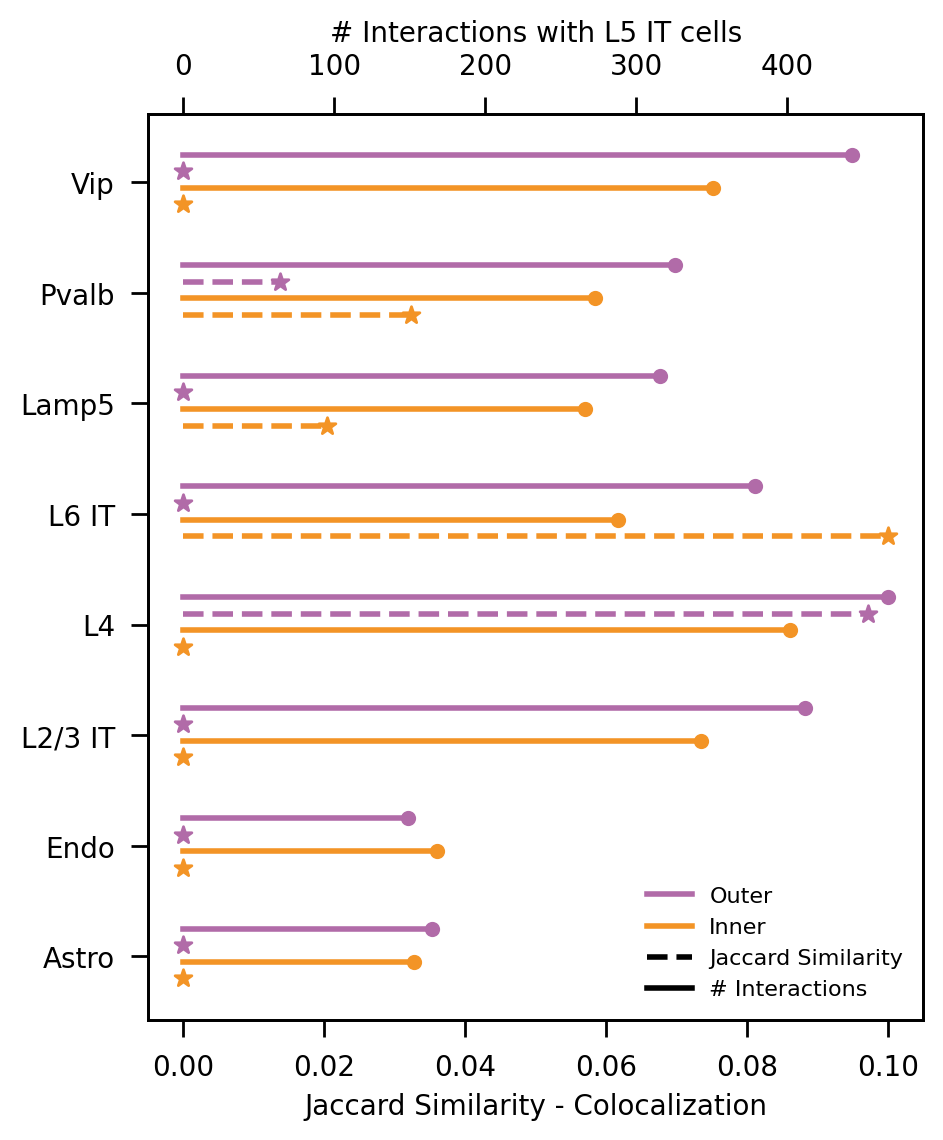

In [17]:
data = data_cc_coloc

# Create the plot
fig, ax = plt.subplots(figsize=(5,6), dpi=200)


# Plot the normalized data as horizontal lolliplots
for i, row in data.iterrows():

    ax.plot([0, row['JS_loc1']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc1']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax.plot([0, row['JS_loc2']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc2']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    

ax2 = ax.twiny() 

for i, row in data.iterrows():
    ax2.plot([0, row['loc1']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax2.scatter([row['loc1']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax2.plot([0, row['loc2']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax2.scatter([row['loc2']], [i + 0.45], color='#B16BA8', s=20, zorder=10)
    

ax.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = labelout_size)


ax.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax2.set_xlabel('# Interactions with L5 IT cells',  fontsize=labelout_size)

axs.tick_params(axis='both', labelsize=labelout_size)



from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Outer'),
    Line2D([0], [0], color='#F39426', lw=2, label='Inner'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'lower right')



L4 neurons were predicted to have the highest interaction rates with both L5 IT neuron groups. While predictions accurately reflected higher counts of LR interactions between outer layer neurons and L4 neurons, the predicted interaction counts with inner layer neurons were unexpectedly high, despite the lack of colocalization. This discrepancy was particularly evident in the case of interactions involving L6 IT neurons. Despite these neurons colocalizing with L5 neurons in the inner part of the layer, CellPhoneDB predictions suggested higher interaction rates with neurons in the outer section. Additionally, there were some cases where L5 IT neurons showed no colocalization, yet a high number of LR interactions was predicted, such as with Vip or L2/L3 IT neurons.

# Figure 1 F: Correlation between interactions and colocalization

Finally, we will compute the correlation between the most colocalizated cells with L5 IT cells and the most interacting cells, to see if we see any relationship. 

In [18]:
## Merge the two result dataframes dataframes
data_correlation = counts_qcell.merge(closest_cells_df, left_index = True, right_on = 'cells')
data_correlation.set_index('cells', inplace = True)
data_correlation.columns = ['CC1', 'CC2', 'JS_CC1', 'JS_CC2']
data_correlation = data_correlation.astype(float)


Text(0.5, 1.0, 'Correlation between colocalization \n and number of interactions')

findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans' not found.
findfont: Font family 'FreeSans'

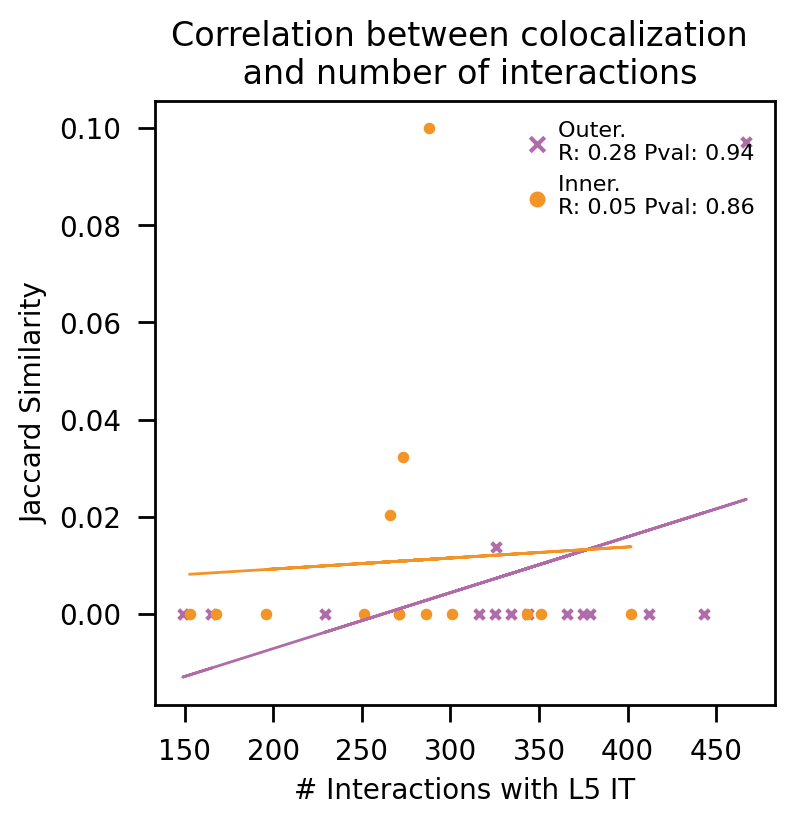

In [19]:
fig, axs = plt.subplots(1, figsize=(4, 4), dpi=200)

axs.scatter(data_correlation['CC2'], data_correlation['JS_CC2'], c = '#B16BA8', s = 12, marker='x', label='Outer. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['CC2'], data_correlation['JS_CC2'])[0], 2), round(spearmanr(data_correlation['CC2'], data_correlation['JS_CC1'])[1], 2)))
axs.scatter(data_correlation['CC1'], data_correlation['JS_CC1'], c ='#F39426', s=10 , label='Inner. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['CC1'], data_correlation['JS_CC1'])[0], 2), round(spearmanr(data_correlation['CC1'], data_correlation['JS_CC1'])[1], 2)))
# Calculate and plot regression line for 'CC2' vs. 'JS_CC2'
m_red, b_red = np.polyfit(data_correlation['CC2'],  data_correlation['JS_CC2'].astype(float), 1)
axs.plot(data_correlation['CC2'], m_red * data_correlation['CC2'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'Cancer_orange' vs. 'JS_orange'
m_orange, b_orange = np.polyfit(data_correlation['CC1'], data_correlation['JS_CC1'].astype(float), 1)
axs.plot(data_correlation['CC1'], m_orange * data_correlation['CC1'] + b_orange, color='#F39426', linewidth=1)

plt.ylabel('Jaccard Similarity', fontsize=labelout_size)
plt.xlabel('# Interactions with L5 IT', fontsize=labelout_size)
plt.tick_params(axis='both', which='major', labelsize=labelout_size)
plt.legend(frameon = False, fontsize = label_size, loc = 'upper right', markerscale=1.5,handlelength=0.5,  handletextpad=0.7)
plt.title('Correlation between colocalization \n and number of interactions', fontsize=title_size)


# join  plot

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

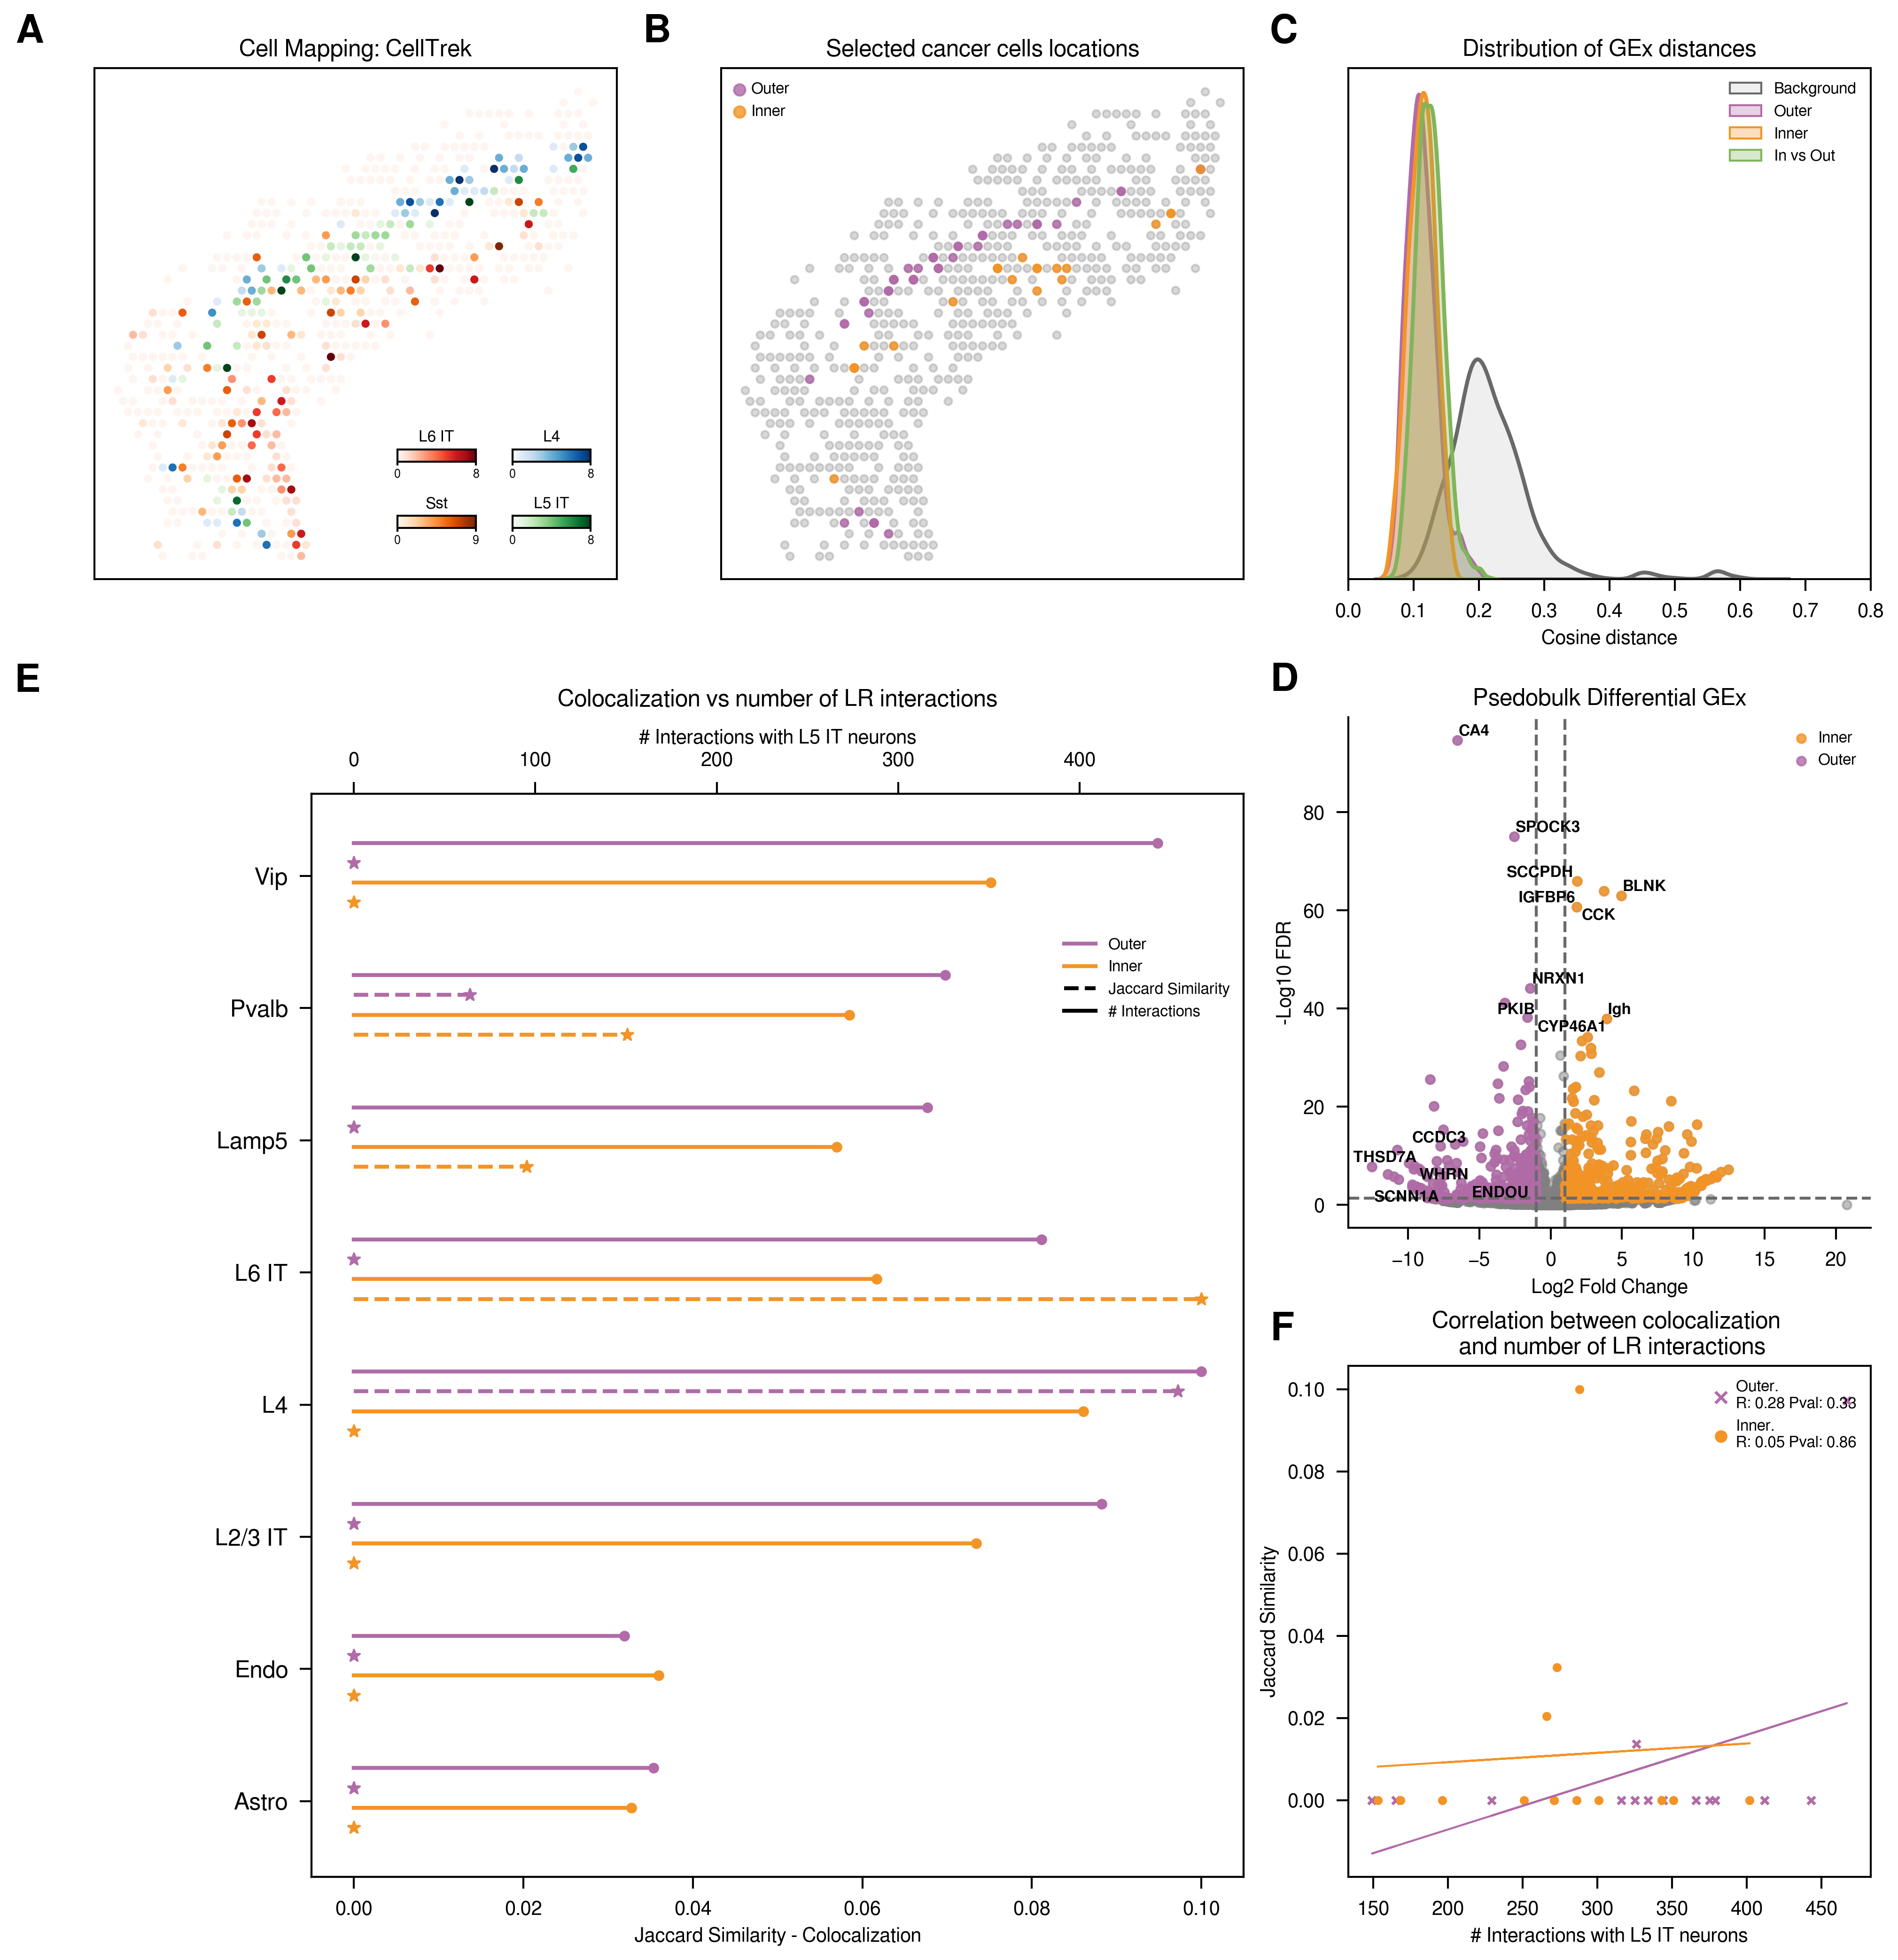

In [27]:
# Create a new figure with a custom grid for subplots
fig2 = plt.figure(figsize=(22, 17), dpi=300)

# Create a GridSpec with an uneven layout
gs2 = gridspec.GridSpec(3, 4, figure=fig2, hspace=0.27)

# First row - 3 plots
ax1 = fig2.add_subplot(gs2[0, :1]) # Span 1 column
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, size=20, weight='bold')
ax2 = fig2.add_subplot(gs2[0, 1:2]) # Span 1 column
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, size=20, weight='bold')
ax3 = fig2.add_subplot(gs2[0, 2:3]) # Span 2 columns
ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, size=20, weight='bold')


# Second row - 1 tall plot and 2 plots one on top of the other
ax4 = fig2.add_subplot(gs2[1:, :2]) # Span 2 rows and 2 columns for the tall plot
ax4.text(-0.319, 1.0938, 'E', transform=ax4.transAxes, size=20, weight='bold')
ax5 = fig2.add_subplot(gs2[1, 2:3]) # Span 2 columns for the top small plot
ax5.text(-0.15, 1.05, 'D', transform=ax5.transAxes, size=20, weight='bold')
ax6 = fig2.add_subplot(gs2[2, 2:3]) # Span 2 columns for the bottom small plot
ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, size=20, weight='bold')

#####################################################################################################################################################
#####################################################################################################################################################
####################### MAPPING #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

abundances_figure(abundances, coords, ax1, query_cells, 'Cell Mapping: CellTrek', colorbar = True, colorbar_bounds = colorbar_bounds)

#####################################################################################################################################################
#####################################################################################################################################################
####################### DISTANCES ###################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################


sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = ax3, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(CC2_cosine, label = 'Outer', color = '#B16BA8' ,ax = ax3, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(CC1_cosine, label = 'Inner', color = '#F39426', ax = ax3, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(CC1_CC2), label = 'In vs Out', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2, ax=ax3)


legend = ax3.legend(frameon = False, fontsize = label_size, loc= 'upper right')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

ax3.set_xlim(0,0.8)
ax3.set_xlabel('Cosine distance', fontsize=labelout_size)
ax3.set_ylabel('')
ax3.set_yticks([])
ax3.tick_params(axis='both', which='major', labelsize=labelout_size)
ax3.set_title('Distribution of GEx distances', fontsize=title_size)


#####################################################################################################################################################
#####################################################################################################################################################
####################### VOLCANO #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

# Scatter plot specifying points of interest
# Let's say significant points are those with abs(log fold change) > 1 and -log p-value > 1.5
ax5.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
ax5.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20, label = 'Inner')
ax5.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20 , label = 'Outer')

texts = []
for index, row in top_pval.iterrows():
        texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['genes.human'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['padj'] > 0.05:
            continue 
        if row['genes.human'] not in top_pval.index.tolist():
            texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['genes.human'], fontsize=label_size, fontweight = 'bold'))

adjust_text(texts, ax=ax5)


# Highlighting the threshold line for p-value
ax5.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
ax5.axvline(x=1, color='dimgray', linestyle='--')
ax5.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
ax5.set_xlabel('Log2 Fold Change', fontsize=labelout_size)
ax5.set_ylabel('-Log10 FDR', fontsize=labelout_size)
ax5.set_title('Psedobulk Differential GEx', fontsize=title_size)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.tick_params(axis='both', which='major', labelsize=labelout_size)
ax5.legend(frameon = False, fontsize = label_size, handlelength=0.5)

#####################################################################################################################################################
#####################################################################################################################################################
####################### INTERACTIONS ################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################



# Create the plot
# Plot the normalized data as horizontal lolliplots



for i, row in data.iterrows():

    ax4.plot([0, row['JS_loc1']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc1']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax4.plot([0, row['JS_loc2']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc2']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    

ax42 = ax4.twiny() 

for i, row in data.iterrows():
    ax42.plot([0, row['loc1']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax42.scatter([row['loc1']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax42.plot([0, row['loc2']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax42.scatter([row['loc2']], [i + 0.45], color='#B16BA8', s=20, zorder=10)
    



ax4.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax42.set_xlabel('# Interactions with L5 IT neurons',  fontsize=labelout_size)

ax4.tick_params(axis='both', labelsize=labelout_size)
ax4.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = title_size)
ax4.set_title('Colocalization vs number of LR interactions', fontsize=title_size, y = 1.07)




from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Outer'),
    Line2D([0], [0], color='#F39426', lw=2, label='Inner'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax4.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'upper right', bbox_to_anchor=(1, 0.88))

pos = ax4.get_position()
pos.x0 = pos.x0 + 0.07
pos.y1 = pos.y1 - 0.032
ax4.set_position(pos)


#####################################################################################################################################################
#####################################################################################################################################################
####################### LOCATION ####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################
background_coords = meta_cells_total.drop_duplicates('spot')[['spot', 'imagerow', 'imagecol']]

xs_b = background_coords.imagerow.values
ys_b = background_coords.imagecol.values

xs_c1 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1'].imagerow.values
ys_c1 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC1'].imagecol.values

xs_c2 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2'].imagerow.values
ys_c2 = meta_cells_charting_l5[meta_cells_charting_l5.cluster == 'CC2'].imagecol.values

ax2.scatter(ys_b, -xs_b, s=15, c = 'grey', alpha = 0.3)
ax2.scatter(ys_c2, -xs_c2, s=15, c = '#B16BA8', alpha = 0.8, label = 'Outer')
ax2.scatter(ys_c1, -xs_c1, s=15, c = '#F39426', alpha = 0.8, label = 'Inner')
ax2.set_title('Selected cancer cells locations', fontsize=title_size)
ax2.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax2.legend(frameon = False,  markerscale=1.5,handlelength=0.5,  handletextpad=0.5, fontsize = label_size, loc = 'upper left')


#####################################################################################################################################################
#####################################################################################################################################################
####################### CORRELATION #################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

ax6.scatter(data_correlation['CC2'], data_correlation['JS_CC2'], c = '#B16BA8', s = 15, marker='x', label='Outer. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['CC2'], data_correlation['JS_CC2'])[0], 2), round(spearmanr(data_correlation['CC2'], data_correlation['JS_CC2'])[1], 2)))
ax6.scatter(data_correlation['CC1'], data_correlation['JS_CC1'], c ='#F39426', s=13 , label='Inner. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['CC1'], data_correlation['JS_CC1'])[0], 2), round(spearmanr(data_correlation['CC1'], data_correlation['JS_CC1'])[1], 2)))
# Calculate and plot regression line for 'Cancer_red' vs. 'JS_red'
m_red, b_red = np.polyfit(data_correlation['CC2'], data_correlation['JS_CC2'].astype(float), 1)
ax6.plot(data_correlation['CC2'], m_red * data_correlation['CC2'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'Cancer_orange' vs. 'JS_orange'
m_orange, b_orange = np.polyfit(data_correlation['CC1'], data_correlation['JS_CC1'].astype(float), 1)
ax6.plot(data_correlation['CC1'], m_orange * data_correlation['CC1'] + b_orange, color='#F39426', linewidth=1)

ax6.set_ylabel('Jaccard Similarity', fontsize=labelout_size)
ax6.set_xlabel('# Interactions with L5 IT neurons', fontsize=labelout_size)
ax6.tick_params(axis='both', which='major', labelsize=labelout_size)
ax6.legend(frameon = False, fontsize = label_size, loc = 'upper right', markerscale=1.5,handlelength=0.5,  handletextpad=0.7)
ax6.set_title('Correlation between colocalization \n and number of LR interactions', fontsize=title_size)

